In [39]:
import base64
import io
import os
from io import BytesIO
from time import time
from typing import Union

import PIL
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from PIL import Image

In [2]:
!wget -O anh-con-cho-51.jpg https://hoanghamobile.com/tin-tuc/wp-content/uploads/2024/04/anh-con-cho-51.jpg

--2025-05-07 23:14:45--  https://hoanghamobile.com/tin-tuc/wp-content/uploads/2024/04/anh-con-cho-51.jpg
Resolving hoanghamobile.com (hoanghamobile.com)... 103.28.37.130
Connecting to hoanghamobile.com (hoanghamobile.com)|103.28.37.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125309 (122K) [image/jpeg]
Saving to: ‘anh-con-cho-51.jpg.1’

anh-con-cho-51.jpg. 100%[===================>] 122.37K  --.-KB/s    in 0.05s   

2025-05-07 23:14:45 (2.32 MB/s) - ‘anh-con-cho-51.jpg.1’ saved [125309/125309]



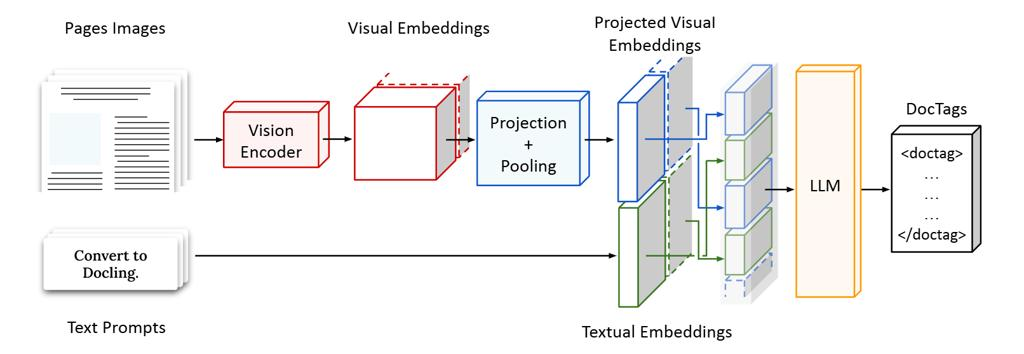

In [48]:
from thangquang_01_image_caption import get_image_base64
from IPython.display import display

img_path = "../data/raw/imgs/image.png"
img = get_image_base64(image_path=img_path)
im = Image.open(BytesIO(base64.b64decode(img)))

display(im)

## With Gemini

In [50]:
from thangquang_01_image_caption import generate_caption_with_gemini

In [51]:
print(generate_caption_with_gemini(image_path=img_path))

INFO:thangquang_01_image_caption:Sending Request
INFO:thangquang_01_image_caption:Time taken: 2.118220090866089 seconds


A diagram illustrating a document tagging process.  Pages of images are fed into a vision encoder, which generates visual embeddings. These embeddings are then projected and pooled, resulting in projected visual embeddings.  These are combined with textual embeddings, processed by an LLM (Large Language Model), and finally output as DocTags.


## With Local Model

In [8]:
from huggingface_hub import notebook_login

notebook_login()

In [42]:
import torch
from accelerate.test_utils.testing import get_backend
from transformers import (
    AutoModelForCausalLM,  # mô hình chính
    AutoProcessor,
    BlipForConditionalGeneration,
    BlipProcessor,
)  # Lớn hơn AutoTokenizer (phù hợp cho mô hình MultiModal)


def get_llm_vision_local(checkpoint: str = "Salesforce/blip-image-captioning-base"):
    try:
        processor = AutoProcessor.from_pretrained(checkpoint)
        model = AutoModelForCausalLM.from_pretrained(checkpoint)
    except ValueError:
        processor = BlipProcessor.from_pretrained(checkpoint)
        model = BlipForConditionalGeneration.from_pretrained(checkpoint)
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None

    return processor, model

In [43]:
processor, model = get_llm_vision_local()

/home/thangquang/CODE/multimodal-rag-baseline/env/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [44]:
def generate_caption_with_local_model(
    image: PIL.Image.Image = None,
    image_path: str = None,
    prompt: str = "Describe this image in detail to be used as a caption. Focus on the main subjects, actions, and setting.",
    processor_and_model: Union[tuple, None] = None,
) -> str:
    if not processor_and_model:
        processor, model = get_llm_vision_local()
    else:
        processor, model = processor_and_model
    start_time = time()
    if image is None and image_path is None:
        raise ValueError("Either image or image_path must be provided")
    if image is None:
        image = Image.open(image_path)
    device, _, _ = get_backend()
    # Encode the prompt with the image data
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values
    generated_ids = model.generate(pixel_values=pixel_values, max_length=100)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    end_time = time()
    print(f"Time taken: {end_time - start_time} seconds")
    return generated_caption

In [45]:
print(generate_caption_with_local_model(
    image_path=img_path, 
    prompt="a photography of",
    processor_and_model=(processor, model)
))

Time taken: 1.8990421295166016 seconds
a diagram of the process
